In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/drive/MyDrive/file12'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


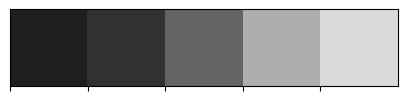

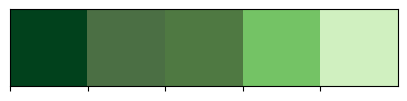

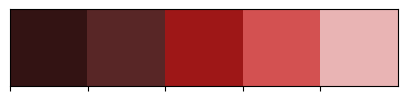

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm

X_train = []
y_train = []
image_size = 150
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']  # Replace with your actual labels

# Process images from the training directory
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/f3000', 'Training', label)
    for filename in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_train.append(img)
                y_train.append(label)
            else:
                print(f"Error: Unable to read image {img_path}")
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

# Process images from the testing directory
for label in labels:
    folderPath = os.path.join('/content/drive/MyDrive/f3000', 'Testing', label)
    for filename in tqdm(os.listdir(folderPath)):
        img_path = os.path.join(folderPath, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X_train.append(img)
                y_train.append(label)
            else:
                print(f"Error: Unable to read image {img_path}")
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 74/74 [00:17<00:00,  4.14it/s]


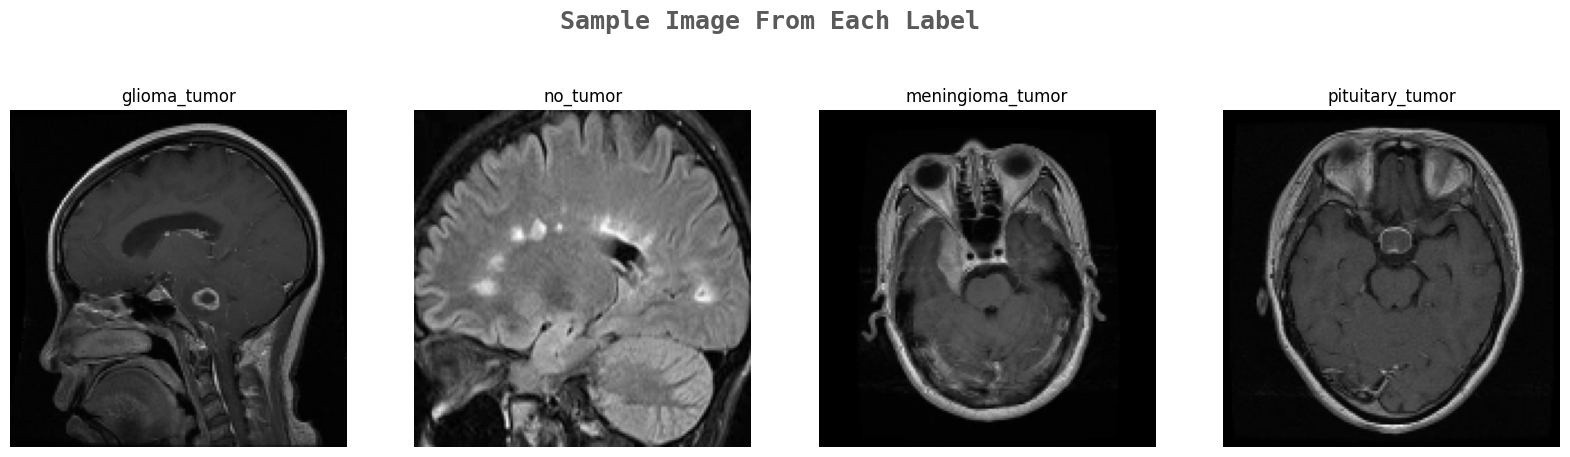

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)


In [8]:
X_train.shape

(3274, 150, 150, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
!pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 949.8 kB/s eta 0:00:00


In [12]:
from efficientnet.keras import EfficientNetB0
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

# Define image size
image_size = 150

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

# Path to training and testing folders
train_dir = '/content/drive/MyDrive/f3000/Training'
test_dir = '/content/drive/MyDrive/f3000/Testing'

# Create data generators with data augmentation for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical'
)

# Load EfficientNetB0 model with random initialization
effnet = EfficientNetB0(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

# Add custom layers on top of the pre-trained model
model = Sequential([
    effnet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Add dropout
    Dense(32, activation='relu'),
    Dropout(0.5),  # Add dropout
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size
)


Found 2870 images belonging to 4 classes.
Found 404 images belonging to 4 classes.
Epoch 1/10
89/89 [==============================] - 98s 437ms/step - loss: 1.4743 - accuracy: 0.3235 - val_loss: 1.4778 - val_accuracy: 0.1823
Epoch 2/10
89/89 [==============================] - 39s 437ms/step - loss: 1.2720 - accuracy: 0.3946 - val_loss: 1.9204 - val_accuracy: 0.2370
Epoch 3/10
89/89 [==============================] - 37s 415ms/step - loss: 1.1598 - accuracy: 0.4894 - val_loss: 2.1311 - val_accuracy: 0.2474
Epoch 4/10
89/89 [==============================] - 37s 414ms/step - loss: 1.0977 - accuracy: 0.5363 - val_loss: 1.5681 - val_accuracy: 0.3620
Epoch 5/10
89/89 [==============================] - 35s 391ms/step - loss: 1.0380 - accuracy: 0.5592 - val_loss: 2.0258 - val_accuracy: 0.3359
Epoch 6/10
89/89 [==============================] - 35s 395ms/step - loss: 1.0024 - accuracy: 0.5916 - val_loss: 1.4817 - val_accuracy: 0.4010
Epoch 7/10
89/89 [==============================] - 36s 408

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 75, 75, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 75, 75, 32)           0         ['stem_bn[0][0]']         

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


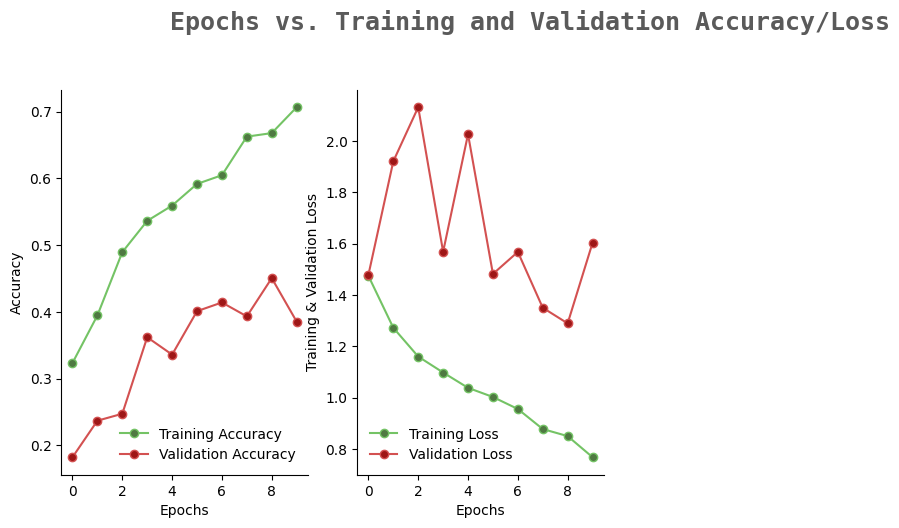

In [17]:
filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(7,5))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


11/11 [==============================] - 3s 149ms/step


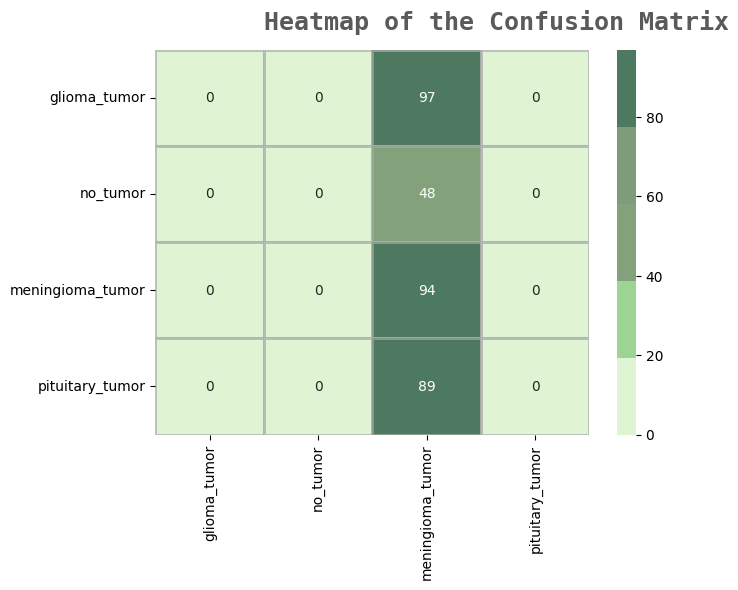

In [19]:
fig,ax=plt.subplots(1,1,figsize=(7,5))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [20]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        print('The model predicts that there is no tumor')
    elif p==2:
        p='Meningioma Tumor'
    else:
        p='Pituitary Tumor'

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [21]:
uploader = widgets.FileUpload()
display(uploader)


FileUpload(value={}, description='Upload')

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])